In [1]:
# import models
from keras.layers import *
from keras.models import Sequential, Model, load_model
from keras import optimizers, losses
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay 
from scipy import fftpack
from keras.optimizers import Adam
import metrics
import time
import numpy as np

from utils import *

seed = 202404
np.random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

2024-10-07 12:02:50.224865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 12:02:50.224895: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 12:02:50.226140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 12:02:50.231556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 12:02:50.743854: W tensorflow/compiler/tf2

2 Physical GPUs, 1 Logical GPU


2024-10-07 12:02:52.013232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 12:02:52.013460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 12:02:52.046142: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
# define hybrids attention model
def channel_attention(input_tensor, reduction_ratio=16):
    channel_avg = GlobalAveragePooling1D()(input_tensor)
    channel_dense1 = Dense(units=int(input_tensor.shape[-1]) // reduction_ratio, activation='relu')(channel_avg)
    channel_dense2 = Dense(units=int(input_tensor.shape[-1]), activation='sigmoid')(channel_dense1)
    channel_attention = Multiply()([input_tensor, Reshape(target_shape=(1, -1))(channel_dense2)])
    return channel_attention

def spatial_attention(input_tensor):
    spatial_avg = Lambda(lambda x: K.mean(x, axis=2))(input_tensor)
    spatial_max = Lambda(lambda x: K.max(x, axis=2))(input_tensor)
    spatial_concat = Reshape(target_shape=(-1, 2))(concatenate([spatial_avg, spatial_max],axis=1))
    spatial_conv1 = Conv1D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(spatial_concat)
    spatial_attention = Multiply()([input_tensor, Reshape(target_shape=(-1, 1))(spatial_conv1)])
    return spatial_attention

def cbam_block(input_tensor):
    channel_att = channel_attention(input_tensor)
    spatial_att = spatial_attention(channel_att)
    cbam_output = Add()([channel_att, spatial_att])
    return cbam_output

def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
    data = signal
    p_predict_indx = np.argmax(p_predict)
    s_predict_indx = np.argmax(s_predict)
    s_labels_indx = np.argmax(s_labels)
    p_labels_indx = np.argmax(p_labels)
    
    time = np.linspace(0, sample_num, sample_num)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(511)
    plt.plot(time, data[:,0], 'k',label='Z')
    ymin,ymax = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax1.get_ylim()
    print('ymin, ymax:', ymin, ymax)
    # plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    # plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    # plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    # plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    plt.vlines(p_labels_indx, ymin+0.2, ymax-0.2, color='deepskyblue', linewidth=2, label='P-arrival')
    plt.vlines(s_labels_indx, ymin+0.2, ymax-0.2, color='tomato', linewidth=2)
    plt.vlines(p_predict_indx, ymin, ymax, color='tomato', linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx, ymin, ymax, color='deepskyblue', linewidth=2, linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlim([0, 6000])
    ax1.set_xticklabels([])
    # ax1.set_xticks([])
    
    ax = fig.add_subplot(512) 
    plt.plot(time, data[:,1], 'k',label='N')
    # ymin,ymax = ax1.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2, label='S-arrival')
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--')
    legend_properties = {'weight':'bold'}
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(513) 
    plt.plot(time, data[:,2], 'k',label='E')
    # ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    # ymin, ymax = ax.get_ylim()
    plt.vlines(p_labels_indx,ymin+0.2,ymax-0.2,color='deepskyblue',linewidth=2)
    plt.vlines(s_labels_indx,ymin+0.2,ymax-0.2,color='tomato',linewidth=2)
    plt.vlines(p_predict_indx,ymin,ymax,color='tomato',linewidth=2, linestyle='--', label='P-arrival prediction')
    plt.vlines(s_predict_indx,ymin,ymax,color='deepskyblue',linewidth=2, linestyle='--', label='S-arrival prediction')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ymin,yma = ax.get_ylim()
    ax.set_xticklabels([])
    # ax.set_xticks([])
    
    ax = fig.add_subplot(514) 
    plt.plot(time, p_predict, label='P-wave predicted', linestyle='--')
    plt.plot(time, s_predict, label='S-wave predicted', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    # plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    # plt.ylim([-1, 1])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(515) 
    plt.plot(time, p_labels, label='P-wave label', linestyle='--')
    plt.plot(time, s_labels, label='S-wave label', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    plt.tight_layout()

In [3]:
# build AE network architecture
D1, D2, D3, D4, D5 = 32, 16, 8, 4, 2
inp = Input(shape=(6000, 3))
k1, k2, k3 = 3, 6, 9

In [4]:
# define encoder block
encoder1 = Dense(D1, activation='relu')(inp)
mixed_1 = Conv1D(D1, kernel_size=k1, padding='same', strides=2, activation='linear')(encoder1)
mixed_2 = Conv1D(D1, kernel_size=k2, padding='same', strides=2, activation='linear')(encoder1)
mixed_3 = Conv1D(D1, kernel_size=k3, padding='same', strides=2, activation='linear')(encoder1)
encoder1 = concatenate([mixed_1, mixed_2, mixed_3], axis=-1)
encoder1 = LeakyReLU(0.2)(encoder1)
encoder1 = Dropout(0.1)(encoder1)
# encoder1 = AveragePooling1D(2)(encoder1)

attention1 = cbam_block(encoder1)

encoder2 = Dense(D2, activation='relu')(attention1)
encoder2_0 = Conv1D(D2, kernel_size=k1, strides=2, padding='same')(encoder2)
encoder2_1 = Conv1D(D2, kernel_size=k2, strides=2, padding='same')(encoder2)
encoder2_2 = Conv1D(D2, kernel_size=k3, strides=2, padding='same')(encoder2)
encoder2 = concatenate([encoder2_0, encoder2_1, encoder2_2], axis=-1)
encoder2 = LeakyReLU(0.2)(encoder2)
encoder2 = Dropout(0.1)(encoder2)
# encoder2 = AveragePooling1D(2)(encoder2)

attention2 = cbam_block(encoder2)

encoder3 = Dense(D3, activation='relu')(attention2)
encoder3_0 = Conv1D(D3, kernel_size=k1, strides=2, padding='same')(encoder3)
encoder3_1 = Conv1D(D3, kernel_size=k2, strides=2, padding='same')(encoder3)
encoder3_2 = Conv1D(D3, kernel_size=k3, strides=2, padding='same')(encoder3)
encoder3 = concatenate([encoder3_0, encoder3_1, encoder3_2], axis=-1)
encoder3 = LeakyReLU(0.2)(encoder3)
encoder3 = Dropout(0.1)(encoder3)
# encoder3 = AveragePooling1D(2)(encoder3)

attention3 = cbam_block(encoder3)

encoder4 = Dense(D4, activation='relu')(attention3)
encoder4_0 = Conv1D(D4, kernel_size=k1, strides=2, padding='same')(encoder4)
encoder4_1 = Conv1D(D4, kernel_size=k2, strides=2, padding='same')(encoder4)
encoder4_2 = Conv1D(D4, kernel_size=k3, strides=2, padding='same')(encoder4)
encoder4 = concatenate([encoder4_0, encoder4_1, encoder4_2], axis=-1)
encoder4 = LeakyReLU(0.2)(encoder4)
encoder4 = Dropout(0.1)(encoder4)
# encoder4 = AveragePooling1D(2)(encoder4)

attention4 = cbam_block(encoder4)

# define bottleneck block
bottleneck = GRU(units=32, activation='tanh', return_sequences=True)(attention4) 
bottleneck = GRU(units=8, activation='tanh', return_sequences=True)(bottleneck)  
bottleneck = Flatten()(bottleneck)
encoder = Dense(2, activation='softmax')(bottleneck)

# define decoder blocks
decoder4 = Dense(D4, activation='relu')(encoder4)
decoder4_0 = Conv1D(D4, k1, padding='same')(decoder4)
decoder4_1 = Conv1D(D4, k2, padding='same')(decoder4)
decoder4_2 = Conv1D(D4, k3, padding='same')(decoder4)
decoder4 = concatenate([decoder4_0, decoder4_1, decoder4_2], axis=-1)
decoder4 = LeakyReLU(0.1)(decoder4)
# decoder4 = BatchNormalization()(decoder4)
decoder4 = concatenate([decoder4, attention4], axis=-1)
decoder4 = UpSampling1D(2)(decoder4)
# decoder4 = BatchNormalization()(decoder4)

decoder3 = Dense(D3, activation='relu')(decoder4)
decoder3_0 = Conv1D(D3, k1, padding='same')(decoder3)
decoder3_1 = Conv1D(D3, k2, padding='same')(decoder3)
decoder3_2 = Conv1D(D3, k3, padding='same')(decoder3)
decoder3 = concatenate([decoder3_0, decoder3_1, decoder3_2], axis=-1)
decoder3 = LeakyReLU(0.1)(decoder3)
# decoder3 = BatchNormalization()(decoder3)
decoder3 = concatenate([decoder3, attention3], axis=-1)
decoder3 = UpSampling1D(2)(decoder3)
# decoder3 = BatchNormalization()(decoder3)

decoder2 = Dense(D2, activation='relu')(decoder3)
decoder2_0 = Conv1D(D2, k1, padding='same')(decoder2)
decoder2_1 = Conv1D(D2, k2, padding='same')(decoder2)
decoder2_2 = Conv1D(D2, k3, padding='same')(decoder2)
decoder2 = concatenate([decoder2_0, decoder2_1, decoder2_2], axis=-1)
decoder2 = LeakyReLU(0.1)(decoder2)
# decoder2 = BatchNormalization()(decoder2)
decoder2 = concatenate([decoder2, attention2], axis=-1)
decoder2 = UpSampling1D(2)(decoder2)
# decoder2 = BatchNormalization()(decoder2)

decoder1 = Dense(D1, activation='relu')(decoder2)
decoder1_0 = Conv1D(D1, k1, padding='same')(decoder1)
decoder1_1 = Conv1D(D1, k2, padding='same')(decoder1)
decoder1_2 = Conv1D(D1, k3, padding='same')(decoder1)
decoder1 = concatenate([decoder1_0, decoder1_1, decoder1_2], axis=-1)
decoder1 = LeakyReLU(0.1)(decoder1)
# decoder1 = BatchNormalization()(decoder1)
decoder1 = concatenate([decoder1, attention1], axis=-1)
decoder1 = UpSampling1D(2)(decoder1)
# decoder1 = BatchNormalization()(decoder1)


# decoder = Dense(36, activation='relu')(decoder1)
# decoder = Dense(18, activation='relu')(decoder)
# decoder = Dense(2, activation='sigmoid')(decoder)
# decoder1 = Conv1D(8, 2, padding='same', activation='tanh')(decoder1)
#decoder1 = Conv1D(D1, 2, padding='same', activation='relu')(decoder1)
decoder1 = Dense(D1, activation='relu')(decoder1)
decoder = Conv1D(1, 3, padding='same', activation='sigmoid')(decoder1)
# define the output block of the phase-picking network
picking_model = Model(inputs=inp, outputs=decoder)
picking_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 6000, 3)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 6000, 32)             128       ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 3000, 32)             3104      ['dense[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3000, 32)             6176      ['dense[0][0]']               
                                                                                              

## Phase Picking

In [3]:
learning_rate = 0.001  # Specify your learning rate

batch1 = 256
epochs1 = 100
optimizer = Adam(learning_rate=learning_rate)

phase_data = np.load('./data/signal_events/random_10w_1006_bp.npy')
phase_data = phase_data[:, :, :]
max_values_per_event = np.max(phase_data, axis=1)

# Normalize each component of each event by dividing by its maximum value
normalized_phase_data = phase_data / max_values_per_event[:, np.newaxis, :]
phase_label = np.load('./data/arrival_time/guassian_picking_labels_Pwave_txed_signal_random_10w.npy')
phase_label = phase_label[:, :, :]

X_train_phase, X_test_phase, y_train_phase, y_test_phase = train_test_split(normalized_phase_data, phase_label, test_size=0.15, random_state=202404)
print(f'shape of training set: {X_train_phase.shape}\tshape of training label: {y_train_phase.shape}')

shape of training set: (85000, 6000, 3)	shape of training label: (85000, 6000, 1)


In [6]:
# train cluster network
picking_model.compile(loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])
# picking_model.compile(loss=['CategoricalCrossentropy', 'binary_crossentropy'], loss_weights=[0.5, 0.5], optimizer='adam', metrics=['accuracy'])
#encoder.compile(optimizer='adam', loss= MixedLoss(), metrics=['accuracy'])
csv_logger = CSVLogger(f'./logs/r1_log/P_wave_phase_picking_10w_random_1006_{batch1}_{epochs1}_loss.csv')

# Addig stopping condition
es=EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc=ModelCheckpoint(f'./model/r2_model/P_wave_phase_picking_10w_random_1006_{batch1}_{epochs1}.h5', monitor='val_loss', mode='min', save_best_only=True)


# Tic-Toc
start=time.time()
history_phase = picking_model.fit(X_train_phase, y_train_phase, verbose=1, epochs=epochs1,
                                  validation_split=0.05, shuffle=True, batch_size=batch1,  callbacks=[csv_logger, es, mc])
end = time.time()
running_time = end - start
print('time cost : %.3f sec' % running_time)

Epoch 1/100


2024-10-06 20:28:50.914873: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-06 20:28:54.045189: I external/local_xla/xla/service/service.cc:168] XLA service 0x75795889ed30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-06 20:28:54.045214: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4500, Compute Capability 8.6
2024-10-06 20:28:54.052574: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1728235734.104073 3940739 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


316/316 [==============================] - 132s 252ms/step - loss: 0.0477 - accuracy: 0.9538 - val_loss: 0.0173 - val_accuracy: 0.9565
Epoch 2/100


/home/g202321530/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


316/316 [==============================] - 69s 218ms/step - loss: 0.0137 - accuracy: 0.9565 - val_loss: 0.0117 - val_accuracy: 0.9565
Epoch 3/100
316/316 [==============================] - 69s 218ms/step - loss: 0.0116 - accuracy: 0.9564 - val_loss: 0.0112 - val_accuracy: 0.9564
Epoch 4/100
316/316 [==============================] - 69s 218ms/step - loss: 0.0111 - accuracy: 0.9564 - val_loss: 0.0107 - val_accuracy: 0.9564
Epoch 5/100
316/316 [==============================] - 69s 219ms/step - loss: 0.0107 - accuracy: 0.9564 - val_loss: 0.0104 - val_accuracy: 0.9564
Epoch 6/100
316/316 [==============================] - 69s 218ms/step - loss: 0.0103 - accuracy: 0.9564 - val_loss: 0.0101 - val_accuracy: 0.9564
Epoch 7/100
316/316 [==============================] - 69s 218ms/step - loss: 0.0101 - accuracy: 0.9564 - val_loss: 0.0103 - val_accuracy: 0.9564
Epoch 8/100
316/316 [==============================] - 69s 217ms/step - loss: 0.0099 - accuracy: 0.9564 - val_loss: 0.0103 - val_accurac

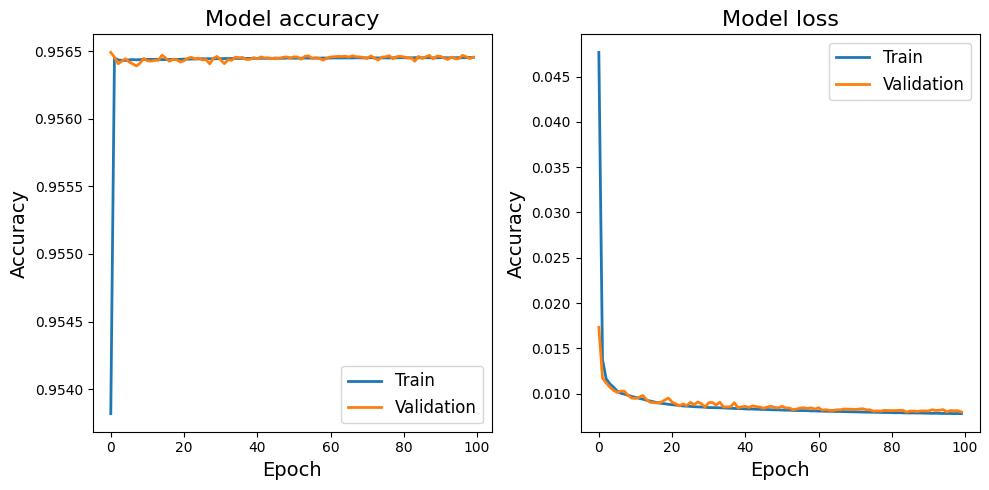

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(history_phase.history['accuracy'], linewidth=2)
plt.plot(history_phase.history['val_accuracy'], linewidth=2)
plt.title('Model accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='lower right',fontsize='large', title_fontsize='large')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_phase.history['loss'], linewidth=2)
plt.plot(history_phase.history['val_loss'], linewidth=2)
plt.title('Model loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize='large', title_fontsize='large')
plt.tight_layout()
plt.savefig(f'./figs/r1_loss/P_wave_phase_picking_10w_random_1006_{batch1}_{epochs1}_loss.png', dpi=300)
plt.savefig(f'./figs/r1_loss/P_wave_phase_picking_10w_random_1006_{batch1}_{epochs1}_loss.pdf', dpi=300)
plt.show()

### Test data vsulization

In [12]:
phase_model = load_model(f'./model/r2_model/P_wave_phase_picking_10w_random_1006_{batch1}_{epochs1}.h5')
test_phase_out = phase_model.predict(X_test_phase)

469/469 [==============================] - 8s 15ms/step


In [5]:
def pwave_signal_label_visualization(signal, p_predict, p_labels, sample_num):
    data = signal
    p_predict_indx = np.argmax(p_predict)
    p_labels_indx = np.argmax(p_labels)
    time = np.linspace(0, sample_num, sample_num)
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(511)
    plt.plot(time, data[:,0], 'k',label='Z')
    ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    ymin, ymax = ax1.get_ylim()
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.vlines(p_labels_indx, ymin+0.2, ymax-0.2, color='deepskyblue', linewidth=2, label='P-arrival')
    plt.vlines(p_predict_indx, ymin, ymax, color='tomato', linewidth=2, linestyle='--', label='P-arrival label')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Amplitude', fontsize=12)
    plt.xlim([0, 6000])
    ax1.set_xticklabels([])
    
    ax = fig.add_subplot(512) 
    plt.plot(time, data[:,1], 'k',label='N')
    ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    ymin, ymax = ax.get_ylim()
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.vlines(p_labels_indx, ymin+0.2, ymax-0.2, color='deepskyblue', linewidth=2, label='P-arrival')
    plt.vlines(p_predict_indx, ymin, ymax, color='tomato', linewidth=2, linestyle='--')
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    ax.set_xticklabels([])
    
    ax = fig.add_subplot(513) 
    plt.plot(time, data[:,2], 'k',label='E')
    ymin,yma = ax1.get_ylim()
    # plt.vlines(spt,ymin,yma,color='r',linewidth=2)
    # plt.vlines(sst,ymin,yma,color='b',linewidth=2)
    legend_properties = {'weight':'bold'}
    ymin, ymax = ax.get_ylim()
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.vlines(p_labels_indx, ymin+0.2, ymax-0.2, color='deepskyblue', linewidth=2, label='P-arrival')
    plt.vlines(p_predict_indx, ymin, ymax, color='tomato', linewidth=2, linestyle='--')
    plt.ylabel('Amplitude', fontsize=12) 
    plt.xlim([0, 6000])
    ymin,yma = ax.get_ylim()
    
    ax = fig.add_subplot(514) 
    plt.plot(time, p_predict, label='P-wave predicted', linestyle='--', color='orange')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    # plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    
    ax = fig.add_subplot(515) 
    plt.plot(time, p_labels, label='P-wave label', linestyle='--')
    plt.legend(loc = 'upper right', borderaxespad=0., prop=legend_properties)
    plt.ylabel('Probability', fontsize=12) 
    plt.xlabel('Sample', fontsize=12) 
    plt.xlim([0, 6000])
    plt.tight_layout()


MAE and $sigma$ of p: 0.1362s	0.3203s
Percentage of samples within ±1s for P-wave: 96.68%


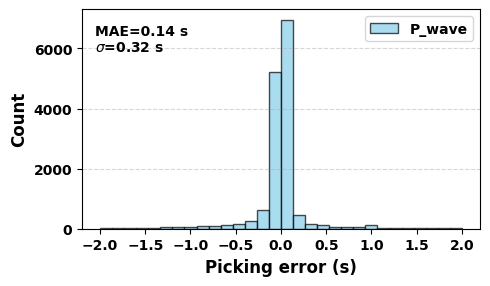

In [31]:
def to_numpy(array):
    array = np.array(array)
    return array


pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(test_phase_out[i, :, 0])
    #pre_ind_s = np.argmax(test_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_test_phase[i, :, 0])
    #lab_ind_s = np.argmax(y_test_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    #pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    #lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
#pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
#lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p = err_indx_p/100
#err_indx_s = lab_indx_s - pre_indx_s
#err_indx_s = err_indx_s/100

err_indx_p[(err_indx_p > 2) | (err_indx_p < -2)] = 0
#err_indx_s[(err_indx_s > 4) | (err_indx_s < -4)] = 0

mae_p = np.mean(np.abs(err_indx_p - np.mean(err_indx_p)))
sigma_p = np.std(err_indx_p)
#mae_s = np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))
#sigma_s = np.std(err_indx_s)

# Calculate the percentage of errors within ±1 second
within_1s_p = np.sum(np.abs(err_indx_p) <= 1) / len(err_indx_p) * 100
#within_1s_s = np.sum(np.abs(err_indx_s) <= 1) / len(err_indx_s) * 100

print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s')
print(f'Percentage of samples within ±1s for P-wave: {within_1s_p:.2f}%')
#print(f'Percentage of samples within ±1s for S-wave: {within_1s_s:.2f}%')


plt.figure(figsize=(5, 3))  # Set figure size
plt.hist(err_indx_p, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', transform=plt.gcf().transFigure)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['P_wave'], prop={'weight': 'bold'})
plt.tight_layout()
plt.savefig(f'./figs/r2_picking/dist/P_wave_picking_testing_P_10w_random_{batch1}_{epochs1}.pdf', bbox_inches="tight", dpi=150)
plt.savefig(f'./figs/r2_picking/dist/P_wave_picking_testing_P_10w_random_{batch1}_{epochs1}.png', bbox_inches="tight", dpi=150)
plt.show()


In [30]:
err_indx_p_1 = np.sum((err_indx_p > 1) | (err_indx_p< -1))

# Print the result
print(f'Number of err_indx_p elements greater than 1: {err_indx_p_1}\nlength of testing data: {X_test_phase.shape[0]}\nOutlier ratio: {(err_indx_p_1/(X_test_phase.shape[0]))*100:.3f}%')

Number of err_indx_p elements greater than 1: 1100
length of testing data: 15000
Outlier ratio: 7.333%


In [22]:
((3922-3765)/3922)*100

4.003059663437022

(15000, 6000, 1)


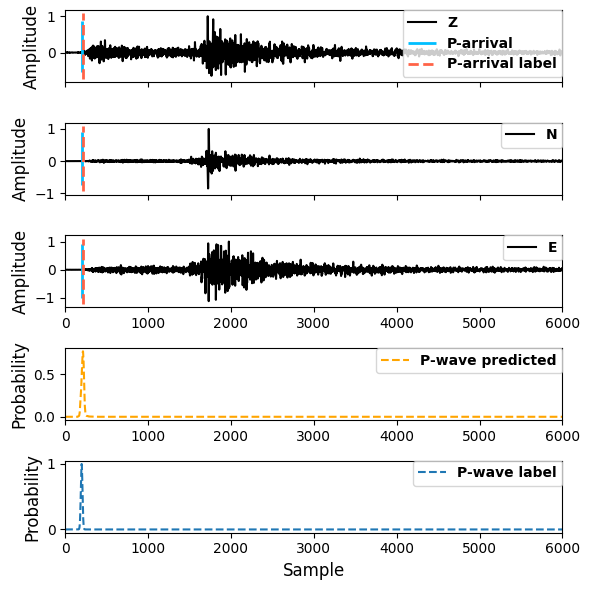

In [28]:
print(test_phase_out.shape)

m = 3333

# def plot_labels_signals(signal, p_predict, s_predict, p_labels, s_labels, sample_num):
pwave_signal_label_visualization(X_test_phase[m, :, :], p_predict=test_phase_out[m, :, 0], p_labels=y_test_phase[m, :, 0], sample_num=6000)
plt.savefig(f'./figs/r2_picking/picking/P_wave_picking_testing_10w_random_{m}.pdf', bbox_inches="tight", dpi=150)
plt.savefig(f'./figs/r2_picking/picking/P_wave_picking_testing_10w_random_{m}.png', bbox_inches="tight", dpi=150)
plt.show()

### Train data visualization

In [7]:
train_phase_out = phase_model.predict(X_train_phase)
print(train_phase_out.shape)

2657/2657 [==============================] - 39s 15ms/step
(85000, 6000, 1)


MAE and $sigma$ of p: 0.0569s	0.1004s
Percentage of samples within ±1s for P-wave: 84.21%


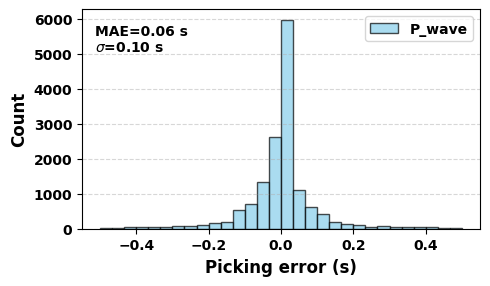

In [35]:
pre_indx_p = []
pre_indx_s = []
lab_indx_p = []
lab_indx_s = []
for i in range (test_phase_out.shape[0]):
    # print(y_test_phase[i, :, :0].shape)
    pre_ind_p = np.argmax(train_phase_out[i, :, 0])
    #pre_ind_s = np.argmax(train_phase_out[i, :, 1])
    lab_ind_p = np.argmax(y_train_phase[i, :, 0])
    #lab_ind_s = np.argmax(y_train_phase[i, :, 1])
    pre_indx_p.append(pre_ind_p)
    #pre_indx_s.append(pre_ind_s)
    lab_indx_p.append(lab_ind_p)
    #lab_indx_s.append(lab_ind_s) 
    
pre_indx_p = to_numpy(pre_indx_p)
#pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
#lab_indx_s = to_numpy(lab_indx_s)

pre_indx_p = to_numpy(pre_indx_p)
#pre_indx_s = to_numpy(pre_indx_s)
lab_indx_p = to_numpy(lab_indx_p)
#lab_indx_s = to_numpy(lab_indx_s)

err_indx_p = lab_indx_p - pre_indx_p
err_indx_p = err_indx_p/100
#err_indx_s = lab_indx_s - pre_indx_s
#err_indx_s = err_indx_s/100

err_indx_p[(err_indx_p > 0.5) | (err_indx_p < -0.5)] = 0
#err_indx_s[(err_indx_s > 4) | (err_indx_s < -4)] = 0

mae_p = np.mean(np.abs(err_indx_p - np.mean(err_indx_p)))
sigma_p = np.std(err_indx_p)
#mae_s = np.mean(np.abs(err_indx_s - np.mean(err_indx_s)))
#sigma_s = np.std(err_indx_s)

# Calculate the percentage of errors within ±1 second
within_1s_p = np.sum(np.abs(err_indx_p) <= 0.1) / len(err_indx_p) * 100
#within_1s_s = np.sum(np.abs(err_indx_s) <= 1) / len(err_indx_s) * 100

print(f'MAE and $sigma$ of p: {mae_p:.4f}s\t{sigma_p:.4f}s')
print(f'Percentage of samples within ±1s for P-wave: {within_1s_p:.2f}%')
#print(f'Percentage of samples within ±1s for S-wave: {within_1s_s:.2f}%')

plt.figure(figsize=(5, 3))  # Set figure size
plt.hist(err_indx_p, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Adjust bins, color, edgecolor, and transparency
plt.xlabel('Picking error (s)', fontsize=12, fontweight='bold')  # Add x-axis label with custom font size
plt.ylabel('Count', fontsize=12, fontweight='bold')  # Add y-axis label with custom font size
plt.xticks(fontsize=10, fontweight='bold')  # Set font size for x-axis ticks
plt.yticks(fontsize=10, fontweight='bold')  # Set font size for y-axis ticks
plt.text(0.2, 0.8, f'MAE={mae_p:.2f} s\n$\sigma$={sigma_p:.2f} s', fontsize=10, fontweight='bold', transform=plt.gcf().transFigure)
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add grid lines with custom style and transparency
plt.legend(['P_wave'], prop={'weight': 'bold'})
plt.tight_layout()
plt.savefig(f'./figs/r2_picking/dist/P_wave_picking_trainig_P_10w_random_{batch1}_{epochs1}.pdf', bbox_inches="tight", dpi=150)
plt.savefig(f'./figs/r2_picking/dist/P_wave_picking_trainig_P_10w_random_{batch1}_{epochs1}.png', bbox_inches="tight", dpi=150)
plt.show()


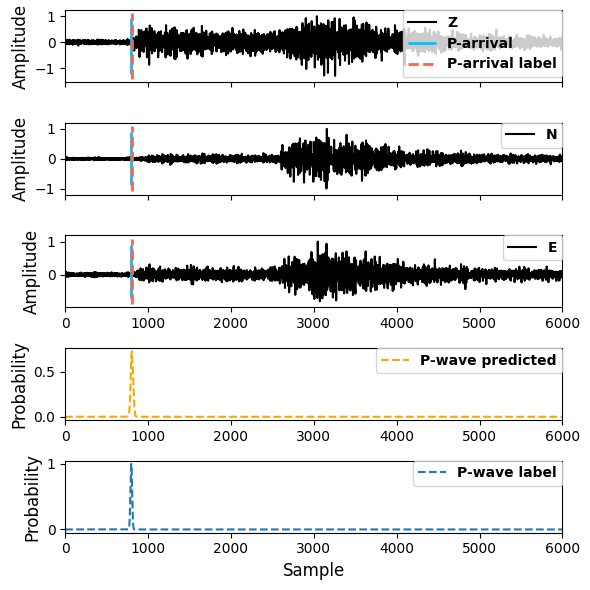

In [34]:
m = 33268

pwave_signal_label_visualization(X_train_phase[m, :, :], p_predict=train_phase_out[m, :, 0], p_labels=y_train_phase[m, :, 0], sample_num=6000)
plt.savefig(f'./figs/r2_picking/picking/P_wave_picking_trainig_10w_random_{m}.pdf', bbox_inches="tight", dpi=150)
plt.savefig(f'./figs/r2_picking/picking/P_wave_picking_trainig_10w_random_{m}.png', bbox_inches="tight", dpi=150)
plt.show()